# Preventive Projects using time series event with potential impact on the mechanical unit

This document present the machine learning model which will help create a preventive maintenance program. The steps for this program are in the following order:

1-Improvement of the dataset by adding similar features together in order to reduce the number of dimensions

2-Reviewing the correlation of the features

3-Creating a model using the random forest. To be noted, I already tested other models and random forest seems to show the best result (gradient boosting gave the same kind of result). Further more, the feature importance which comes with the random forest package is really helpful to reduce the number of dimensions without having to use the PCA method.

4- Reduction of the dimensions based on features importance, features correlation and engineering point of view

5- Test model for the new features


In [1]:
#Import the appropriate library for data manipulation

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
from scipy import stats
import datetime


In [2]:
#import the model library
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
dataset=pd.read_csv('preventive.csv')

Since this model is a real use case, I decided to rename all features.
Only the weather and temperature which were obtained via web scraping will be shown with their real name.

In [4]:
#Presentation of the features
dataset.columns

Index(['Time_1', 'Time_3', 'Int_1', 'Int_2', 'Categorie_1', 'Categorie_2',
       'Time_2', 'Int_3', 'Int_4', 'Int_5', 'Int_6', '-15 and under',
       '-10 to -14', '-5 to -9', '-0 to -4', '15 and over', '10 to 14',
       '5 to 9', '1 to 4', 'Snow', 'Rain', 'Ice Storm',
       'Classification_feature', 'Int_18', 'Time_Sum', 'Freezing_days',
       'higher than 0', 'All_impact', 'Low_impact', 'Classification',
       'Month_Time_1', 'Snapshot_Month'],
      dtype='object')

In [5]:
# modification of time data from object variable to time variable
dataset['Time_1']=pd.to_datetime(dataset['Time_1'])
dataset['Time_2']=pd.to_datetime(dataset['Time_2'])

In [6]:
#Remove of empty value
dataset=dataset.fillna(0)

#Find time between to event
dataset['Time_Sum']=(dataset['Time_2']-dataset['Time_1'])/np.timedelta64(1,'D')


#creation of a new features of only freezing days
dataset['Freezing_days']=dataset['-15 and under']+dataset['-10 to -14']+dataset['-5 to -9']+dataset['-0 to -4']

#Creation of a new features of only days with higher than 0 temperature
dataset['higher than 0']=dataset['15 and over']+dataset['10 to 14']+dataset['5 to 9']+dataset['1 to 4']

#Creation of a new features which represent an event on a unit
dataset['Low_impact']=dataset['Int_5']+dataset['Int_6']

#Since we are doing preventive maintenance and the average lifespan of a unit has an average of 270 with a 
#standard deviation of 120. Being able to predict its failure in the next 90 days would be a big plus value
dataset['Classification']=dataset['Classification_feature'].apply(lambda x: 1 if x<=90 else 0)
dataset['Month_Time_1']=dataset['Time_1'].apply(lambda x: x.month)

# Review of possible features

Selection of the features that will train the future model based on the correlations of those features.

In [7]:
columns=pd.DataFrame(dataset[[ 
    #'Int_1', Removed since when this features happens, it is already too late
    'Int_2', 
    'Categorie_1',
       'Categorie_2',
   # 'Int_3', Removed since when this features happens, it is already too late
   # 'Int_4',  Removed since when this features happens, it is already too late
    'Int_5', 
    'Int_6',
    'Low_impact', 
       '-15 and under', 
    '-10 to -14',
    '-5 to -9', 
    '-0 to -4',
    '15 and over',
       '10 to 14', 
    '5 to 9', '1 to 4', 
    'Snow', 
    'Rain', 
    'Ice Storm',
    'Freezing_days',
    'higher than 0',  
    'Classification_feature',
     'Int_18', 
    'Time_Sum', 
    'Classification',
       'Month_Time_1']].columns)
columns=columns.rename(columns={0:'features'})




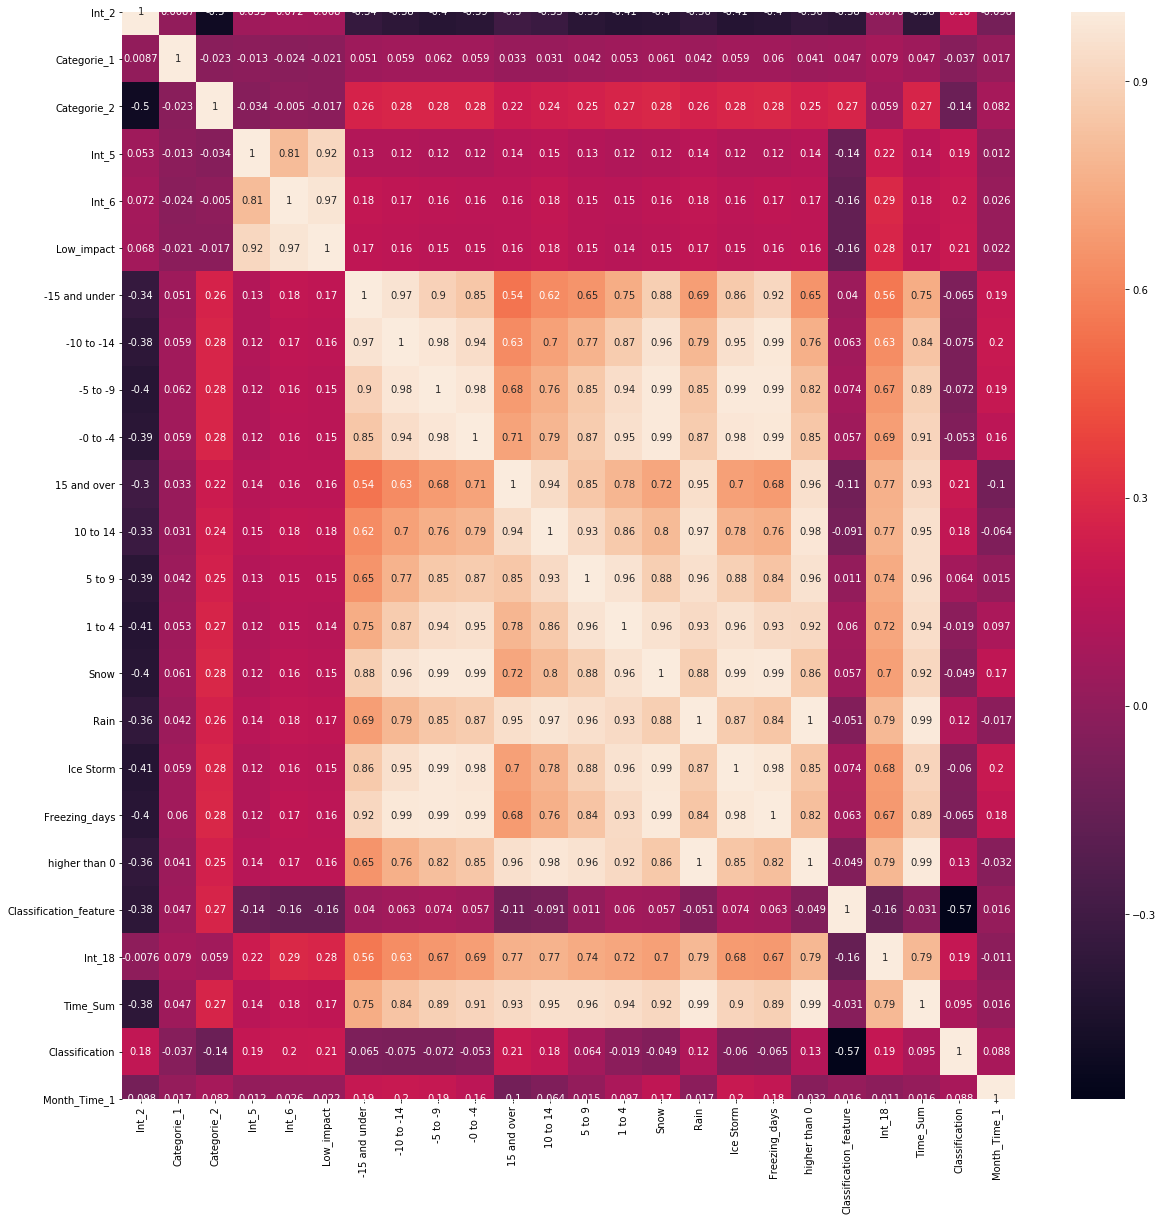

In [8]:
plt.figure(figsize=(20,20))
sns.heatmap(dataset[columns['features'].values].corr(),annot=True)

Graph explanation:

As we can see, we have a really high correlation between temperature features and weather features. Because of this reason, we created the Freezing_days variable and Higher_than_0. Those features will be used to reduce the number of dimensions in the model. We will still show the features importance to make sure that those 2 variables are better than the categories available.

We also have a big correlation between int_5 and int_6 which is normal since they come from a system that classifies these features. By merging those 2 features, we are able to reduce the dimensions without impacting the model. Those assumptions will be shown below.


# Training of model and testing via cross validation


 After reviewing the heatmap figure, a total of 21 features were selected to train and test the model

In [9]:
model_features=pd.DataFrame(dataset[[ 
    'Int_2', 
    'Categorie_1',
       'Categorie_2', 
    'Int_5', 
    'Int_6',
       '-15 and under', 
    '-10 to -14',
    '-5 to -9', 
    '-0 to -4',
    '15 and over',
       '10 to 14', 
    '5 to 9', '1 to 4', 
    'Snow', 
    'Rain', 
    'Ice Storm',
 'Int_18', 
    'Time_Sum', 
    'Freezing_days',
    'higher than 0', 
    'Low_impact', 
       'Month_Time_1', 
#    'Month_Time_2'
]].columns)
model_features=model_features.rename(columns={0:'features'})


Cross validation dataset preparation

In [10]:
x1=dataset[model_features['features'].values]
y1=dataset['Classification']
xTrain, xTest, yTrain, yTest = train_test_split(x1, y1, test_size = 0.3, shuffle=True,stratify=y1)

Training of the model

In [11]:
n=300
rf=RandomForestClassifier(n_estimators=n,max_depth=18)
rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=18, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

Cross validation 

In [12]:
rf.fit(xTrain,yTrain)
predict_rf=rf.predict(xTest)
print(classification_report(yTest,predict_rf))
print(confusion_matrix(yTest,predict_rf))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89     10008
           1       0.80      0.74      0.77      4893

    accuracy                           0.85     14901
   macro avg       0.84      0.82      0.83     14901
weighted avg       0.85      0.85      0.85     14901

[[9078  930]
 [1267 3626]]


Now that the full results are available it is important what they would imply for the business unit. Let’s start with the precision and recall of the 0 classifier:

0 classifier: 

If a unit was falsely classified as 0, it would mean a corrective maintenance which is the current situation of the business. This means that this error is negligible since it would not bring arm or extra cost.

If a unit was falsely classified as 1, it would mean that the preventive maintenance is done too early which will create extra cost and extra work.

Because of those reasons, the focus needs to be on the recall of 0 and the precision of 1 more than on the overall accuracy.

Based on those assumptions, the model will create a position gain when put on production since the overall return of a good preventive maintenance will out weigh the cost a misclassification which will create an early maintenance.


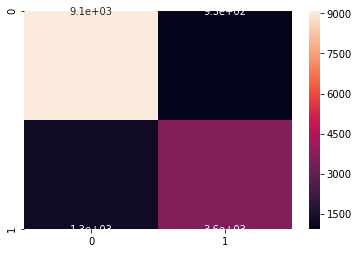

In [13]:
sns.heatmap(confusion_matrix(yTest,predict_rf),annot=True)

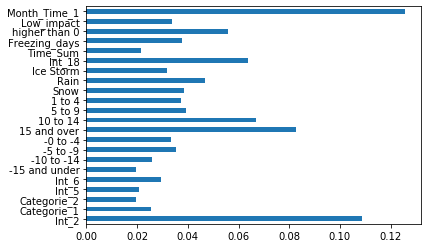

In [14]:
(pd.Series(rf.feature_importances_, model_features['features'].values).plot(kind='barh'))

# New Features Selection Results

After Reviewing the features importance graph, it is possible to reduce the dimensions by taking into account the most important features. The features selected comes from the previous graph, a mechanical engineering point of view and the correlation between the variables. For example, the Low_impact was selected instead of the int5 since it comes from a merger of features int5 and int6. By reducing the number of variables, the model will be easier to explain to the stakeholders but will also reduce noise of some variables.

In [15]:
model_features=pd.DataFrame(dataset[[ 
    'Int_2', 
    'Categorie_1',
       'Categorie_2', 
    'Time_Sum', 
    'Low_impact', 
       'Month_Time_1', 
]].columns)
model_features=model_features.rename(columns={0:'features'})


In [16]:
x1=dataset[model_features['features'].values]
y1=dataset['Classification']
xTrain, xTest, yTrain, yTest = train_test_split(x1, y1, test_size = 0.3, shuffle=True,stratify=y1)

In [17]:
#The n_estimators and max_depth are based on a grid search which will be shown in another document
n=300
rf=RandomForestClassifier(n_estimators=n,max_depth=18)
rf.get_params
rf.fit(xTrain,yTrain)
predict_rf=rf.predict(xTest)
print(classification_report(yTest,predict_rf))
print(confusion_matrix(yTest,predict_rf))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90     10008
           1       0.82      0.76      0.79      4893

    accuracy                           0.87     14901
   macro avg       0.85      0.84      0.85     14901
weighted avg       0.87      0.87      0.87     14901

[[9218  790]
 [1191 3702]]


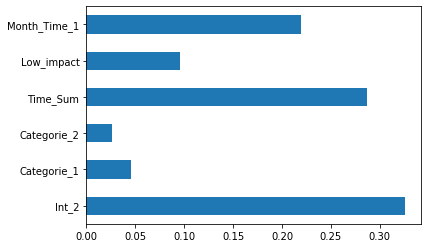

In [18]:
(pd.Series(rf.feature_importances_, model_features['features'].values).plot(kind='barh'))

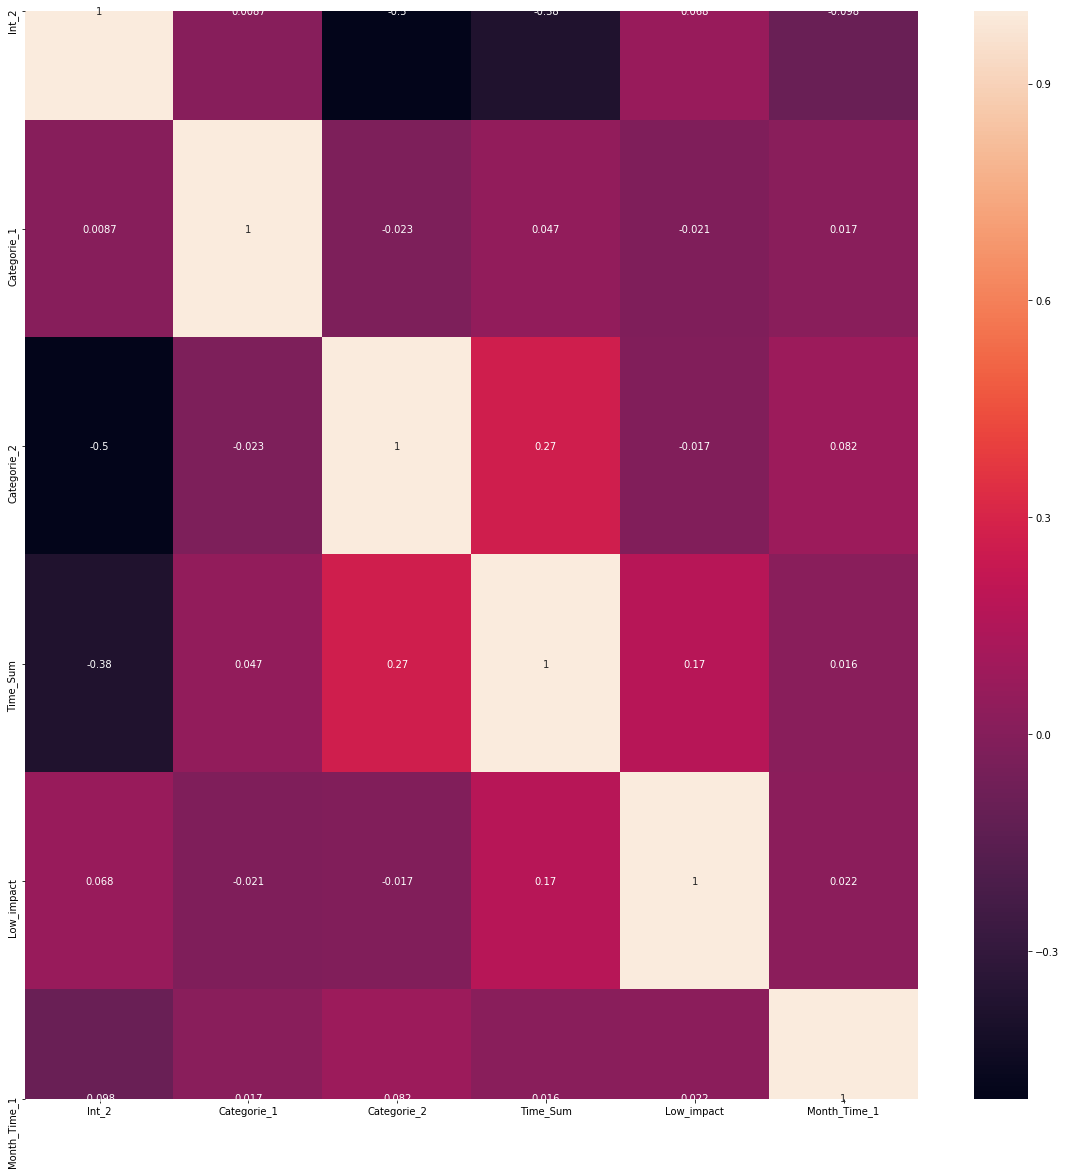

In [19]:
plt.figure(figsize=(20,20))
sns.heatmap(dataset[model_features['features'].values].corr(),annot=True)

# Conclusion

Finally, the model is now ready to be put into production. The final accuracy of the model, based on the cross-validation is 87% and has an 82% precision on the failure classification (preventive maintenance prediction). 
As mentioned before, the recall on failure classification is an important factor since it would mean extra cost and extra labor. Missing a preventive maintenance would only mean the status quo which is not problematic at the moment

This model will be put into production following the next guide line:

The model will be run every 30 days

The unit with the highest probability of failure will be prioritized in a list

All future maintenance will be divided into two categories: preventive maintenance and corrective maintenance.

If the corrective maintenance was not in the prediction list, it will be classified as a False Negative.

A sample from the preventive maintenance unit will be inspected to verify for False positive.

The next step will be to compare the result of the model in development with the result of the model in production